In [29]:
import xarray as xr
import intake

import numpy as np
from xgcm import Grid
from xhistogram.xarray import histogram
import gsw

from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import match_metrics, combine_datasets, merge_variables

In [30]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

### Data in 2-dimensions (e.g. fgco2)

In [58]:
# Grab all desired variables for desired models
variables = ['fgco2','tos','sos']
z_kwargs = {'consolidated': True, 'use_cftime': True}
kwargs = dict(zarr_kwargs=z_kwargs, preprocess=combined_preprocessing, aggregate=False)

query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
             source_id=['GFDL-ESM4']
            )
cat = col.search(**query)
dd = cat.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [59]:
# Combine variables into single dataset
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

ddnow = merge_variables(dd)
ddnow = combine_datasets(
    ddnow,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(ddnow.keys())

['GFDL-ESM4.gr.historical.Omon']

In [60]:
# Check that all variables exist
ddsub = {}
for d in ddnow.keys():
    vs = ddnow[d].data_vars
    if ('tos' in vs) & ('fgco2' in vs) & ('sos' in vs):
        ddsub[d] = ddnow[d]
list(ddsub.keys())

['GFDL-ESM4.gr.historical.Omon']

In [62]:
# Get areacello
cat_metric = col.search(
    variable_id=['areacello'], 
    table_id=['Ofx'], 
    experiment_id=['historical'],
    source_id=['GFDL-ESM4'])
dd_metric = cat_metric.to_dataset_dict(**kwargs)

dddone = match_metrics(ddsub, dd_metric, ['areacello'])

ds = dddone['GFDL-ESM4.gr.historical.Omon'].sel(y=slice(-90,-30)).isel(time=0)
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


<xarray.Dataset>
Dimensions:        (y: 60, bnds: 2, x: 360, vertex: 4)
Coordinates: (12/13)
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(60, 2, 360), meta=np.ndarray>
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 60), meta=np.ndarray>
    time           object 1850-01-16 12:00:00
    time_bounds    (bnds) object dask.array<chunksize=(2,), meta=np.ndarray>
    ...             ...
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 60), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 60), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
    areacello      (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
Data variables:
    sos            (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
    tos            (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
    fgco2          (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
Attributes: (12/42)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    table_id:               Omon
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    variant_info:           N/A
    variant_label:          r1i1p1f1
    version_id:             v20190726
    intake_esm_varname:     None

In [63]:
# Separately calculate dx and dy
def _degrees_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy
    
dlon = ds['lon_bounds'].diff('bnds')
dlon = dlon.where(dlon>0,1) # Account for switch from 360 to 1
dlat = ds['lat_bounds'].diff('bnds')
dx,dy = geo._degrees_to_meters(dlon, dlat, ds['lon'], ds['lat'])
ds['dx']=dx.squeeze()
ds['dy']=dy.squeeze()

In [64]:
# Calculate density
ds['sigma0'] = gsw.sigma0(ds['sos'],ds['tos'])

In [65]:
# Histogram data to temperature space in y-dimension
sigma0_bins = np.arange(26.5,29,0.02)
hs = xr.Dataset()
hs['fgco2-areacello'] = histogram(ds['sigma0'],bins=sigma0_bins,dim=['x','y'],weights=ds['fgco2']*ds['areacello'])
hs['areacello'] = histogram(ds['sigma0'],bins=sigma0_bins,dim=['x','y'],weights=ds['areacello'])
hs['fgco2'] = hs['fgco2-areacello']/hs['areacello']

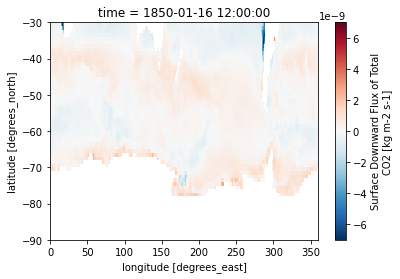

In [71]:
ds['fgco2'].plot()

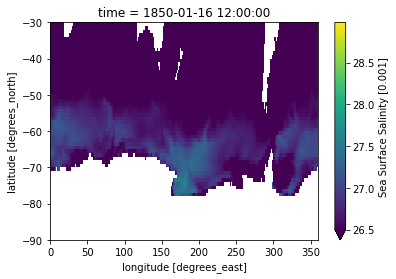

In [70]:
ds['sigma0'].plot(vmin=sigma0_bins[0],vmax=sigma0_bins[-1])

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


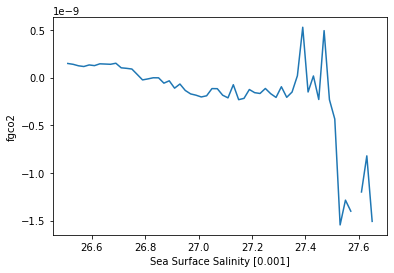

In [72]:
hs['fgco2'].plot()

### Data in 3-dimensions (e.g. PPCO2)

In [78]:
# Grab all desired variables for desired models
variables = ['talk','thetao']
z_kwargs = {'consolidated': True, 'use_cftime': True}
kwargs = dict(zarr_kwargs=z_kwargs, preprocess=combined_preprocessing, aggregate=False)

query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
             source_id=['GFDL-ESM4']
            )
cat = col.search(**query)
dd = cat.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [79]:
# Combine variables into single dataset
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

ddnow = merge_variables(dd)
ddnow = combine_datasets(
    ddnow,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(ddnow.keys())

['GFDL-ESM4.gr.historical.Omon']

In [80]:
# Check that all variables exist
ddsub = {}
for d in ddnow.keys():
    vs = ddnow[d].data_vars
    if ('thetao' in vs) & ('talk' in vs):# & ('sos' in vs):
        ddsub[d] = ddnow[d]
list(ddsub.keys())

['GFDL-ESM4.gr.historical.Omon']

In [83]:
# Get areacello
cat_metric = col.search(
    variable_id=['areacello','volcello'], 
    table_id=['Ofx'], 
    experiment_id=['historical'],
    source_id=['GFDL-ESM4'])
dd_metric = cat_metric.to_dataset_dict(**kwargs)

dddone = match_metrics(ddsub, dd_metric, ['areacello'])

ds = dddone['GFDL-ESM4.gr.historical.Omon'].sel(y=slice(-90,-30)).isel(time=0)
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


<xarray.Dataset>
Dimensions:        (y: 60, bnds: 2, x: 360, lev: 35, vertex: 4)
Coordinates: (12/15)
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(60, 2, 360), meta=np.ndarray>
  * lev            (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 60), meta=np.ndarray>
    ...             ...
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 60), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 60), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
    areacello      (y, x) float32 dask.array<chunksize=(60, 360), meta=np.ndarray>
Data variables:
    thetao         (lev, y, x) float32 dask.array<chunksize=(35, 60, 360), meta=np.ndarray>
    talk           (lev, y, x) float32 dask.array<chunksize=(35, 60, 360), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    variant_info:           N/A
    variant_label:          r1i1p1f1
    version_id:             v20190726
    intake_esm_varname:     None
    original_key:           CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon...

In [84]:
# Separately calculate dx and dy
def _degrees_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy
    
dlon = ds['lon_bounds'].diff('bnds')
dlon = dlon.where(dlon>0,1) # Account for switch from 360 to 1
dlat = ds['lat_bounds'].diff('bnds')
dx,dy = geo._degrees_to_meters(dlon, dlat, ds['lon'], ds['lat'])
ds['dx']=dx.squeeze()
ds['dy']=dy.squeeze()

# Also get dz in meters
ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

In [93]:
# Histogram in the x-dimension and z-dimension, weighted by thickness*dx
thetao_bins = np.arange(-2.5,30,0.1)
hs = xr.Dataset()
hs['talk-weights'] = histogram(ds['thetao'],bins=thetao_bins,dim=['x','lev'],weights=ds['talk']*ds['dx']*ds['dz'])
hs['weights'] = histogram(ds['thetao'],bins=thetao_bins,dim=['x','lev'],weights=ds['dx']*ds['dz'])
hs['talk'] = hs['talk-weights']/hs['weights']

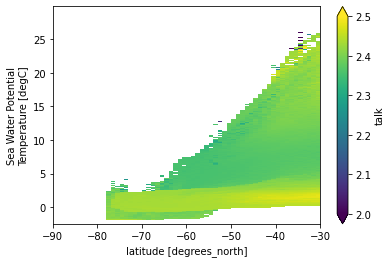

In [96]:
hs['talk'].plot(x='y',vmin=2,vmax=2.5)